# From Python to C -- Via Cython: Get Used to the Flow

In this module, I will walk you though a complete flow from a pure Python implementation to an optimized C-Python hybrid code, step by step.  The process usually takes time, and once you get familiar with it you will skip some steps.  But at the beginning, it's good to do all the steps yourself.

## Step 0: Set up the framework code for the model problem

We will write a Python program to calculate a moving wave.  The model problem requires solving a first-order hyperbolic partial differential equation:

$$
\frac{\partial u}{\partial t} + a \frac{\partial u}{\partial x} = 0
$$

where $x, t$ are the independent variables for space and time, respectively.  $u = u(x, t)$ is the unknown, and $a$ is the wave speed (a constant).

The discretized solution can be obtained by applying [the classic Lax-Wendroff scheme](http://onlinelibrary.wiley.com/doi/10.1002/cpa.3160130205/abstract):

$$
u_j^{n+1} = \frac{\nu(\nu+1)}{2}u_{j-1}^n
          + (1-\nu^2)u_j^n
          + \frac{\nu(\nu-1)}{2}u_{j+1}^n
$$

In the above formula, $\nu = a\Delta t / \Delta x$ is [the Courant–Friedrichs–Lewy (CFL) number](http://www.archive.org/stream/onpartialdiffere00cour#page/n1/mode/2up).  $\Delta x$ and $\Delta t$ are the intervals in space and time grid, respectively.  The subscript $j$ denotes the location in the spatial grid, while the superscript $n$ is the number of time step.

Before getting into the numerical method and its code, create a class ```HarmonicMotion``` to house the settings and grids:

In [1]:
import numpy as np

class HarmonicMotion(object):
    """Abstraction of moving the harmonic forward"""

    def __init__(self, number):
        """
        :param numer: Number of harmonic waves
        :ivar marcher: Must set this attribute to a function that really moves
            the wave.
        """
        # Construct grid.
        nx = 150
        xgrid = np.zeros(nx, dtype='float64')
        freq = 1
        xmin, xmax = -0.5*np.pi / freq, 4*np.pi / freq
        xgrid[:] = np.linspace(xmin, xmax, xgrid.shape[0])
        # Construct initial condition.
        sol = np.zeros_like(xgrid)
        slct = (xgrid > 0) & (xgrid < np.pi / freq)
        sol[slct] = np.sin(number * freq * xgrid)[slct]
        # Assign object attributes.
        self.xgrid = xgrid
        self.sol = sol
        self.soln = self.sol.copy()
        self.cfl = 1.0 # This cannot be greater than unity.
        self.time_increment = self.cfl * (xgrid[1] - xgrid[0]) # Stores as a record.
        self.marcher = None # This should be assigned from outside.

    @property
    def nx(self):
        """Number of points in the spatial grid."""
        return self.xgrid.shape[0]

    def march(self):
        """Call the marcher that moves the wave."""
        self.marcher(self.cfl, self.sol, self.soln)

### Visualization

After the housing ```HarmonicMotion``` class, we use ```matplotlib``` to write a function ```show_step()``` for visualization:

In [2]:
# Magically plot inside the notebook.
%pylab inline

from matplotlib import pyplot as plt

def show_step(marcher, number, steps, **kw):
    """Demonstrate simulation with graphical output"""
    # Set up harmonic driver.
    hm = HarmonicMotion(number)
    hm.marcher = marcher

    # Set up plotter.
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlabel("Location ($\\pi$)")
    ax.set_ylabel("Amplitude")
    # Title.
    titlefmt = "Step #%d/%d"
    text = ax.text(0.5, 1.05, "",
                   transform=ax.transAxes, va="center", ha="center")
    # Content line.
    line, = ax.plot(hm.xgrid/np.pi, hm.soln)

    # Loop to the end and draw.
    it = 0
    while it < steps:
        hm.march()
        it += 1
    text.set_text(titlefmt % (it, steps))
    line.set_ydata(hm.soln)

    # Show it.
    plt.show()

Populating the interactive namespace from numpy and matplotlib


Note the above ```show_step()``` function takes a callable in its first argument.  It's the "marcher" that will be used to do the real calculation.  Before we make a "marcher", ```show_step()``` is useless, but we'll make one now.

## Step 1: The initial Python version

We write a simple Python function to implement the Lax-Wendroff scheme:

In [3]:
def march_python(cfl, sol, soln):
    """Pure Python implementation of Lax-Wendroff scheme"""
    itmax = sol.shape[0]-1
    it = 1
    while it < itmax:
        soln[it] = (1 - cfl*cfl) * sol[it]
        soln[it] += cfl * (cfl+1) / 2 * sol[it-1]
        soln[it] += cfl * (cfl-1) / 2 * sol[it+1]
        it += 1
    sol[:] = soln[:]

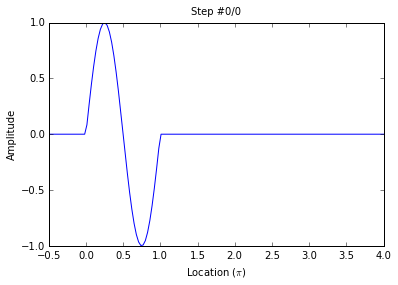

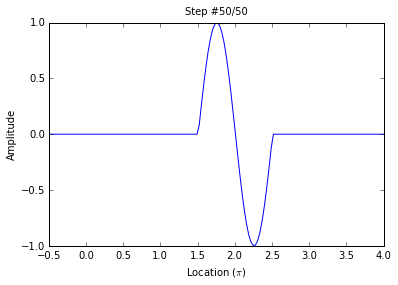

In [4]:
show_step(march_python, 2, 0)
show_step(march_python, 2, 50)

## Step 2: Let Numpy help

Python is slow.  For numerical calculations it is deadly slow, so that we call Numpy for rescue.  First we make a Numpy equivalent to ```march_python()```, and call it ```march_numpy()```:

In [5]:
def march_numpy(cfl, sol, soln):
    """NumPy array-based implementation of Lax-Wendroff scheme"""
    soln[:] = sol[:]
    soln *= 1 - cfl*cfl
    soln[1:] += cfl * (cfl+1) / 2 * sol[:-1]
    soln[:-1] += cfl * (cfl-1) / 2 * sol[1:]
    sol[:] = soln[:]

Make sure it's working:

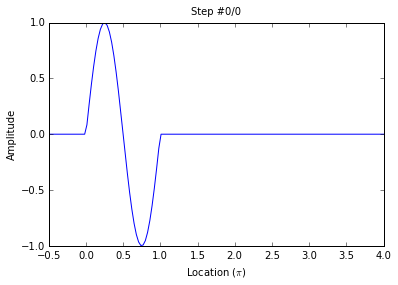

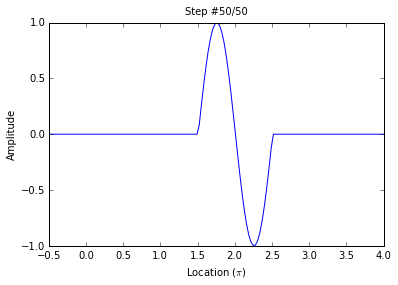

In [6]:
show_step(march_numpy, 2, 0)
show_step(march_numpy, 2, 50)

Thanks to Moore's Law, our computers now run too fast and you can't tell the difference between the two marchers.  Let's do a benchmark to show how good Numpy does.

In [7]:
def run(marcher, steps=300, number=1, **kw):
    """Run simulation without output"""
    hm = HarmonicMotion(number)
    hm.marcher = marcher
    it = 0
    while (it < steps):
        hm.march()
        it += 1
    return hm

In [8]:
%timeit run(march_python)
%timeit run(march_numpy)

10 loops, best of 3: 58.7 ms per loop
1000 loops, best of 3: 2.01 ms per loop


Numpy gave us 30-fold speed-up.  Not bad.

### What's wrong with Numpy

Numpy provides acceptable speed-up.  Then why do we want to use Cython?  The reason can be revealed by comparing the Python and Numpy code.  First, the ```march_python()```:

```python
def march_python(cfl, sol, soln):
    """Pure Python implementation of Lax-Wendroff scheme"""
    itmax = sol.shape[0]-1
    it = 1
    while it < itmax:
        soln[it] = (1 - cfl*cfl) * sol[it]
        soln[it] += cfl * (cfl+1) / 2 * sol[it-1]
        soln[it] += cfl * (cfl-1) / 2 * sol[it+1]
        it += 1
    sol[:] = soln[:]
```

Then ```march_numpy()```:

```python
def march_numpy(cfl, sol, soln):
    """NumPy array-based implementation of Lax-Wendroff scheme"""
    soln[:] = sol[:]
    soln *= 1 - cfl*cfl
    soln[1:] += cfl * (cfl+1) / 2 * sol[:-1]
    soln[:-1] += cfl * (cfl-1) / 2 * sol[1:]
    sol[:] = soln[:]
```

What Numpy does for the speed-up is to move the loop from Python to the C code inside Numpy.  The cost for the speed-up is the cryptic code.

## Step 3: Cython-enhanced code

Before transforming ```march_python()``` to Cython, enable the Cython extension in the iPython notebook:

In [9]:
%load_ext Cython

Then we use the ```%%cython``` magic to port ```march_python()``` to a Cython version:

In [10]:
%%cython

cimport numpy as np

# Initialize NumPy.
np.import_array()

def march_cython(double cfl,
                 np.ndarray[double, ndim=1, mode="c"] sol,
                 np.ndarray[double, ndim=1, mode="c"] soln):
    cdef int itmax = sol.shape[0]-1
    cdef int it = 1
    while it < itmax:
        soln[it] = (1 - cfl*cfl) * sol[it]
        soln[it] += cfl * (cfl+1) / 2 * sol[it-1]
        soln[it] += cfl * (cfl-1) / 2 * sol[it+1]
        it += 1
    sol[:] = soln[:]

Comparing the Python version

```python
def march_python(cfl, sol, soln):
    """Pure Python implementation of Lax-Wendroff scheme"""
    itmax = sol.shape[0]-1
    it = 1
    while it < itmax:
        soln[it] = (1 - cfl*cfl) * sol[it]
        soln[it] += cfl * (cfl+1) / 2 * sol[it-1]
        soln[it] += cfl * (cfl-1) / 2 * sol[it+1]
        it += 1
    sol[:] = soln[:]
```

with the Cython version

```python
def march_cython(double cfl,
                 np.ndarray[double, ndim=1, mode="c"] sol,
                 np.ndarray[double, ndim=1, mode="c"] soln):
    cdef int itmax = sol.shape[0]-1
    cdef int it = 1
    while it < itmax:
        soln[it] = (1 - cfl*cfl) * sol[it]
        soln[it] += cfl * (cfl+1) / 2 * sol[it-1]
        soln[it] += cfl * (cfl-1) / 2 * sol[it+1]
        it += 1
    sol[:] = soln[:]
```

the only thing we did was adding type annotation.

Make sure it works correctly:

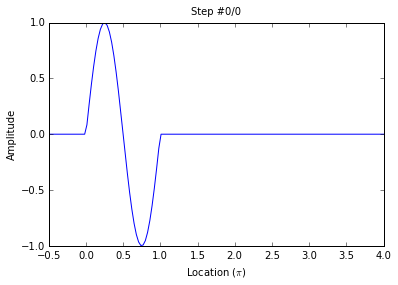

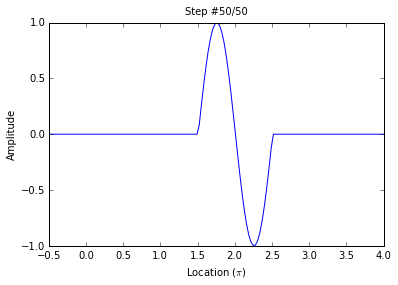

In [11]:
show_step(march_cython, 2, 0)
show_step(march_cython, 2, 50)

In the following benchmark, we see Cython not only makes the code more comprehensible, but also doubles the speed!

In [12]:
%timeit run(march_python)
%timeit run(march_numpy)
%timeit run(march_cython)

10 loops, best of 3: 63.7 ms per loop
100 loops, best of 3: 2.61 ms per loop
1000 loops, best of 3: 885 µs per loop


## Step 4: Go to C if it's not enough

We go to C for two reasons:

1. Faster runtime.
2. Accessing low-level capability.

Here we focus on the first one.

The general idea is to create a Cython wrapper function:

```python
cdef extern:
    void _march_c(double cfl, int nsol, double *sol, double *soln)

@cython.boundscheck(False)
def march_c(double cfl,
            np.ndarray[double, ndim=1, mode="c"] sol,
            np.ndarray[double, ndim=1, mode="c"] soln):
    _march_c(cfl, sol.shape[0], &sol[0], &soln[0])
```

```march_c()``` wraps around the C worker function ```_march_c()```:

```C
void _march_c(double cfl, int nsol, double *sol, double *soln) {
    int itmax = nsol - 1;
    int it = 1;
    while (it < itmax) {
        soln[it] = (1 - cfl*cfl) * sol[it];
        soln[it] += cfl * (cfl+1) / 2 * sol[it-1];
        soln[it] += cfl * (cfl-1) / 2 * sol[it+1];
        it += 1;
    }
    for (it = 0; it < nsol; it++) {
        sol[it] = soln[it];
    }
}
```

It's straight-forwardly ported from the Cython version:

```python
def march_cython(double cfl,
                 np.ndarray[double, ndim=1, mode="c"] sol,
                 np.ndarray[double, ndim=1, mode="c"] soln):
    cdef int itmax = sol.shape[0]-1
    cdef int it = 1
    while it < itmax:
        soln[it] = (1 - cfl*cfl) * sol[it]
        soln[it] += cfl * (cfl+1) / 2 * sol[it-1]
        soln[it] += cfl * (cfl-1) / 2 * sol[it+1]
        it += 1
    sol[:] = soln[:]
```

## Example 1: Build Cython and C

A build system is required to compile the C code into binary.  Cython _alone_ can't do it automatically.  We will need to use ```distutils``` as well.  Now, we will practice by creating the following files and put them in the directory ```01_build_cython_and_c/```:

1. ```setup.py```: The script driving ```distutils```.
2. ```march_c.pyx```: The Cython module for the wrapping function ```march_c()```.
3. ```_march_c.c```: The C file containing the worker function ```_march_c()```.

If something goes wrong when your edit, check the already-written code in the directory ```ref_01_build_cython_and_c/```.

In ```setup.py``` we write:

```python
from __future__ import absolute_import, division, print_function

from distutils.core import setup
from distutils.extension import Extension

from Cython.Build import cythonize
import numpy as np


def main():
    extensions = cythonize([
        Extension("march_c",
                  ["march_c.pyx", "_march_c.c"],
                  include_dirs=[np.get_include()]),
    ])
    setup(
        ext_modules=extensions,
    )


if __name__ == "__main__":
    main()
```

In ```march_c.pyx``` we write:

```python
cimport numpy as np
cimport cython

# Initialize NumPy.
np.import_array()

cdef extern:
    void _march_c(double cfl, int nsol, double *sol, double *soln)

@cython.boundscheck(False)
def march_c(double cfl,
            np.ndarray[double, ndim=1, mode="c"] sol,
            np.ndarray[double, ndim=1, mode="c"] soln):
    _march_c(cfl, sol.shape[0], &sol[0], &soln[0])
```

In ```_march_c.c``` we write:

```C
void _march_c(double cfl, int nsol, double *sol, double *soln) {
    int itmax = nsol - 1;
    int it = 1;
    while (it < itmax) {
        soln[it] = (1 - cfl*cfl) * sol[it];
        soln[it] += cfl * (cfl+1) / 2 * sol[it-1];
        soln[it] += cfl * (cfl-1) / 2 * sol[it+1];
        it += 1;
    }
    for (it = 0; it < nsol; it++) {
        sol[it] = soln[it];
    }
}
```

Build the module with the following command:

```bash
$ python setup.py build_ext --inplace
```

The built module surely contains the ```march_c()``` function:

```bash
$ python -c "import march_c; assert hasattr(march_c, 'march_c')"
```

although it's a lonely function hanging there useless.

## Example 2: Make a package

The `march_c()` function (which calls the real worker code `_march_c()`) alone is useless.  The marcher needs the code to set up the propagating-wave problem: class `HarmonicMotion` and function `show_step()`.  We should house the code in a new Python module file ```core.py``` as a companion with ```march_c.pyx```.  As such, the structure becomes:

1. ```setup.py```: The script driving ```distutils```.
2. ```lax/__init__.py```: An empty, package-enabling file.
3. ```lax/core.py```: The problem framework.
4. ```lax/march_c.pyx```: The Cython module for the wrapping function `march_c()`.
5. ```lax/_march_c.c```: The C file containing the worker function `_march_c()`.

That is, we want a Python package ```lax``` that contains all the code.  Create the directory ```02_make_a_package/``` and make it look like above.  If anything goes wrong with your editing, check ```ref_02_make_a_package/```.

We need to change a bit to ```setup.py```.  It becomes:

```python
from __future__ import absolute_import, division, print_function

from distutils.core import setup
from distutils.extension import Extension

from Cython.Build import cythonize
import numpy as np


def main():
    extensions = cythonize([
        Extension("lax.march_c", # Everything now is under the directory lax/.
                  ["lax/march_c.pyx", "lax/_march_c.c"],
                  include_dirs=[np.get_include()]),
    ])
    setup(
        packages=["lax"], # Tell distutils to make a package.
        ext_modules=extensions,
    )


if __name__ == "__main__":
    main()
```



In addition to `HarmonicMotion` and `show_step()` (**don't forget to write them into the file**), ```lax/core.py``` needs to import `march_c`:

```python
from .march_c import march_c
```

```lax/core.py``` also provides a simple command-line interface:

```python
import argparse

def parse_command_line():
    """Parse the command-line arguments"""
    parser = argparse.ArgumentParser(description="Harmonic Motion")
    def wavenumber(val):
        val = float(val)
        assert val >= 1.0
        return val
    parser.add_argument("-s", dest="steps", action="store",
                        type=int, default=0,
                        help="Steps to run")
    parser.add_argument("-n", dest="number", action="store",
                        type=wavenumber, default=2,
                        help="Number of harmonics; default is %(default)s")
    return parser.parse_args()


def main():
    args = parse_command_line()
    kw = vars(args)
    show_step(march_c, **kw)


if __name__ == '__main__':
    main()
```

The command-line interface allows the module `lax.core` to be invoked as a script:

```bash
$ python -m lax.core -h
usage: core.py [-h] [-s STEPS] [-n NUMBER]

Harmonic Motion

optional arguments:
  -h, --help  show this help message and exit
  -s STEPS    Steps to run
  -n NUMBER   Number of harmonics; default is 2
```

Don't forget to build the binary with

```bash
$ python setup.py build_ext --inplace
```

before running the code.

Note, in the VM that doesn't have a X server, you won't see the plotting.

## Example 3: Compare all

Finally, we put together all the four implementations of our marcher: `march_c()`, `march_cython()`, `march_numpy()`, and `march_python()`.  Create the directory ```03_compare_all/``` and add the following files.

1. ```setup.py```: The script driving ```distutils```.
2. ```lax/__init__.py```: An empty, package-enabling file.
3. ```lax/core.py```: In addition to the problem framework, we add numerical methods implemented in pure Python. 
4. ```lax/march_c.pyx```: The Cython module for the wrapping function `march_c()`.
5. ```lax/_march_c.c```: The C file containing the worker function `_march_c()`.
6. ```lax/march_cython.pyx```: The Cython module for `march_cython()`.

If something goes wrong when your edit, check the already-written code in the directory ```ref_03_compare_all/```.

The ```setup.py``` should be changed to:

```python
from __future__ import absolute_import, division, print_function

from distutils.core import setup
from distutils.extension import Extension

from Cython.Build import cythonize
import numpy as np


def main():
    extensions = cythonize([
        Extension("lax.march_cython", # Bring in the Cython version.
                  ["lax/march_cython.pyx"],
                  include_dirs=[np.get_include()]),
        Extension("lax.march_c",
                  ["lax/march_c.pyx", "lax/_march_c.c"],
                  include_dirs=[np.get_include()]),
    ])
    setup(
        packages=['lax'],
        ext_modules=extensions,
    )


if __name__ == "__main__":
    main()
```

In addition to writing `march_python()` and `march_numpy()` into ```core.py```, import ```march_cython.pyx```:

```python
from .march_cython import march_cython
```

To benchmark the marchers, implement the following function in ```core.py```:

```python
def run(marcher, steps=300, number=1, **kw):
    """Run simulation without output"""
    hm = HarmonicMotion(number)
    hm.marcher = marcher
    it = 0
    while (it < steps):
        hm.march()
        it += 1
    return hm
```

After all the editing, don't forget to build:


```bash
$ python setup.py build_ext --inplace
```

After compilation, we can run the benchmark code:

```bash
$ python -m timeit -s "from lax import core" "core.run(core.march_python)"
10 loops, best of 3: 64.6 msec per loop
$ python -m timeit -s "from lax import core" "core.run(core.march_numpy)"
100 loops, best of 3: 2.1 msec per loop
$ python -m timeit -s "from lax import core" "core.run(core.march_cython)"
1000 loops, best of 3: 817 usec per loop
$ python -m timeit -s "from lax import core" "core.run(core.march_c)"
1000 loops, best of 3: 495 usec per loop
```

The exact number differs from machine to machine, but the work on C really pays off.